# Outliers

In [2]:
# load packages
import numpy as np
import matplotlib.pyplot as plt

In [3]:
d1 = np.loadtxt("outlier_1d.txt")
d2 = np.loadtxt("outlier_2d.txt")
d3 = np.loadtxt("outlier_curve.txt")

print(d1.shape, d2.shape, d3.shape)

(1010,) (1010, 2) (1000, 2)


In [7]:
print(d1)

[21.345 20.2   14.346 ... 16.769 23.633 21.388]


In [8]:
print(d2)

[[12.486 19.387]
 [ 8.184 23.854]
 [12.195 14.544]
 ...
 [ 8.06  20.962]
 [ 8.805 17.617]
 [ 9.798 16.666]]


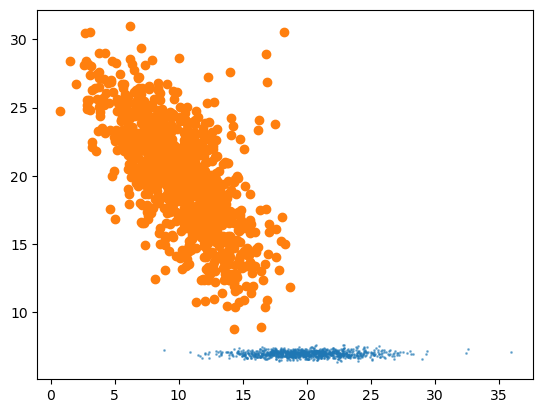

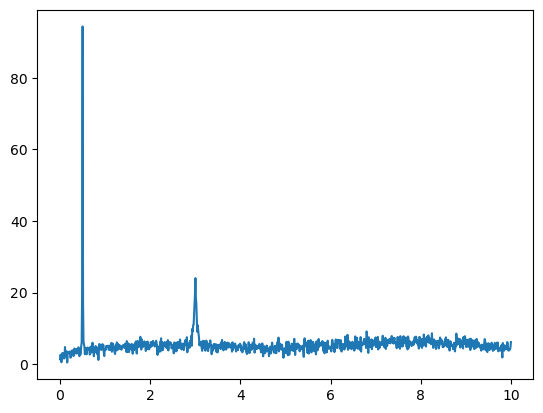

In [10]:
plt.scatter(d1, np.random.normal(7, 0.2, size=d1.size), s=1, alpha=0.5)
plt.scatter(d2[:, 0], d2[:,1])
plt.show() # d1, d2 한 곳에 시각화
plt.plot(d3[:,0], d3[:,1]) # d3 따로 시각화

## Basics

The most basic and most-common way of manually doing outlier pruning on data distributions is to:

1. Model your data as some analytic distribution
2. Find all points below a certain probability
3. Remove them
4. Refit the distributions, and potentially run again from Step 1.

### d1에 대한 이상치

In [20]:
# 이상치에 대한 기준 잡기, z_score Threshold < 3
mean, std = np.mean(d1), np.std(d1)
z_score = np.abs((d1 - mean) / std)
threshold = 3
good = z_score < threshold

Rejection 5 points
z-score of 3 corresponds to a prob of 0.27%


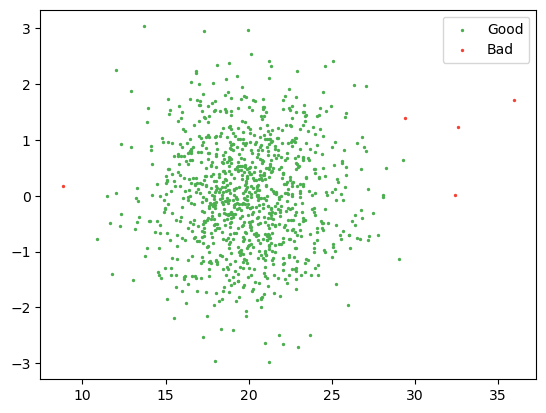

In [21]:
print(f"Rejection {(~good).sum()} points") # ~good = 이상치인 점들이 N개가 있음(sum으로 N개 추출)
from scipy.stats import norm
print(f"z-score of 3 corresponds to a prob of {100*2*norm.sf(threshold):0.2f}%") # Probability of bad
visual_scatter = np.random.normal(size=d1.size)
plt.scatter(d1[good], visual_scatter[good], s=2,label="Good", color = "#4CAF50") # good point show
plt.scatter(d1[~good], visual_scatter[~good], s=2,label="Bad", color = "#F44336") # bad point show
plt.legend() # 범례 작성

### d2에 대한 이상치

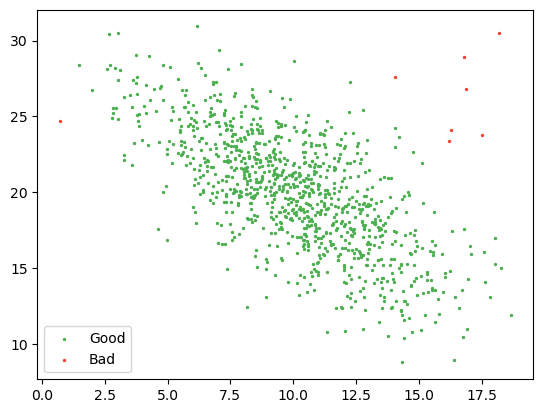

In [25]:
from scipy.stats import multivariate_normal as mn

mean, cov = np.mean(d2, axis=0), np.cov(d2.T)  # d2의 분포를 2차원 가우스로 정량화, 수렴행렬의 평균 구하기
good = mn(mean, cov).pdf(d2) > 0.01/100 # 0.01% 보다 크면 good으로 분류

plt.scatter(d2[good, 0], d2[good, 1], s=2, label="Good", color = "#4CAF50")
plt.scatter(d2[~good, 0], d2[~good, 1], s=2, label="Bad", color = "#F44336")
plt.legend()

### d3 이상치

`numpy.polyfit`와 `numpy.polyval` 함수
NumPy의 `polyfit`과 `polyval` 함수는 다항식과 관련된 작업에 사용되며, 데이터 피팅 및 평가를 위한 강력한 도구입니다. 이 두 함수는 서로 보완적으로 사용됩니다.
1. `numpy.polyfit`
- `polyfit` 함수는 주어진 데이터 포인트에 가장 잘 맞는 다항식을 찾기 위해 `최소제곱법(least squares method)`을 사용합니다. 이 함수는 다항식의 계수를 반환합니다.
2. `numpy.polyval`
- `polyval` 함수는 주어진 다항식을 특정 값에서 평가(evaluate)합니다. 즉, 다항식의 계수와 x 값을 입력받아 결과 값을 계산(평가)합니다.

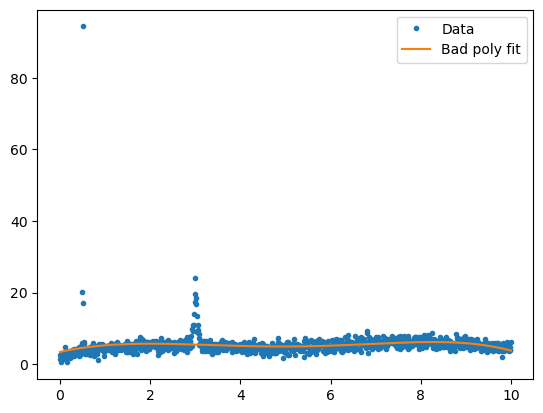

In [26]:
xs, ys = d3.T
p = np.polyfit(xs, ys, deg=5) # 5차 다항식
ps = np.polyval(p, xs)

plt.plot(xs, ys, ".", label="Data")
plt.plot(xs, ps, label="Bad poly fit")
plt.legend()

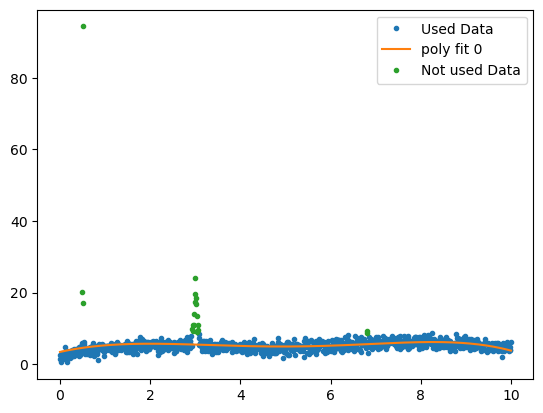

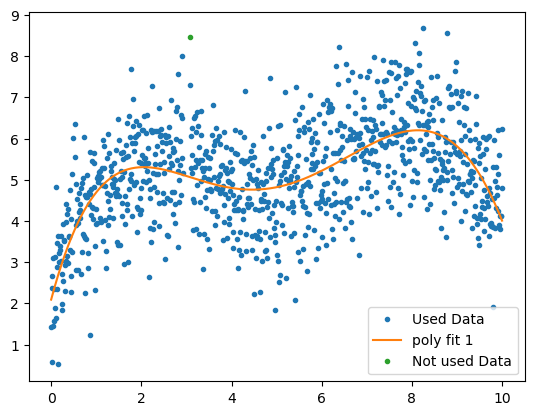

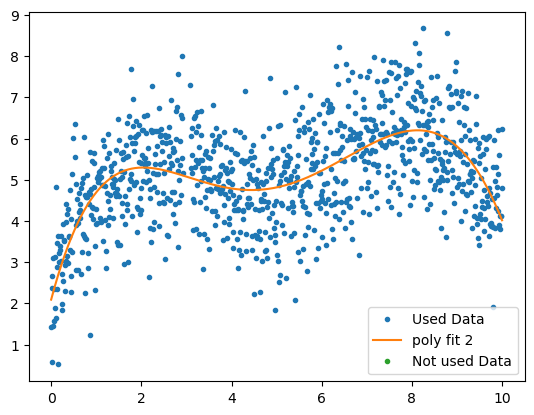

In [32]:
x, y = xs.copy(), ys.copy()
for i in range(5):
    p = np.polyfit(x, y, deg=5)
    ps = np.polyval(p, x)
    good = y - ps < 3 # only remove positive outliers

    x_bad, y_bad = x[~good], y[~good]
    x, y = x[good], y[good]

    plt.plot(x, y, ".", label = "Used Data")
    plt.plot(x, np.polyval(p, x), label = f"poly fit {i}")
    plt.plot(x_bad, y_bad, ".", label = "Not used Data")
    plt.legend()
    plt.show()

    if (~good).sum() == 0:
        break

## 자동화

`sklearn` - LOF (Local Outlier Finder)

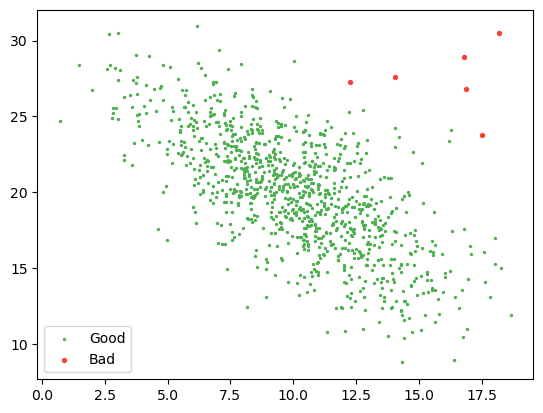

In [33]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.005)
good = lof.fit_predict(d2) == 1
plt.scatter(d2[good, 0], d2[good, 1], s=2, label="Good", color="#4CAF50")
plt.scatter(d2[~good, 0], d2[~good, 1], s=8, label="Bad", color="#F44336")
plt.legend();